### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

# Clase 1: rho1, etiqueta = 1
a_test = np.random.uniform(0, 1, int(n_test/2))
for a in a_test:
    rho, label = ρ1(a)
    data_test.append((rho, label))

# Clase 2: rho2, etiqueta = 2
b_test = np.random.uniform(0, 1, int(n_test/2))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 50
data = []

# Familia 1 → usa ρ1(a), etiqueta = 1
a_values = np.random.uniform(0, 1, int(n_samples/2))
for a in a_values:
    rho, label = ρ1(a)  # rho es matriz 4x4, label = 1
    data.append((rho, label))

# Familia 2 → usa ρ2(b), etiqueta = 2
b_values = np.random.uniform(0, 1, int(n_samples/2))
for b in b_values:
    rho, label = ρ2(b)  # rho es matriz 4x4, label = 2
    data.append((rho, label))

# Mezclar y dividir: 80% entrenamiento, 20% validación
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 20  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 1000
batch_size = int(len(data_train)*0.2)
val_batch_size=int(0.2*batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 100
min_delta = 1e-6
best_val_loss = float('inf')
patience_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
test_suc_history = []
test_err_history = []
test_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):
    
    # Seleccionar un batch aleatorio de data_train
    batch = random.sample(data_train, batch_size)
    
    # Paso de entrenamiento con el batch
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)
    
    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)




    # Early stopping
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"⏹️ Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        break

    # Evaluación en train y test
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_test, err_test, inc_test = evaluate_model(params, data_test)

    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    test_suc_history.append(suc_test)
    test_err_history.append(err_test)
    test_inc_history.append(inc_test)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"test_suc={suc_test:.3f}, test_err={err_test:.3f}, test_inc={inc_test:.3f}")

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
print(f"  Éxito promedio     = {suc_test:.4f}")
print(f"  Error promedio     = {err_test:.4f}")
print(f"  Inconcluso promedio = {inc_test:.4f}")




Entrenando:   0%|          | 0/1000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/1000 [07:01<116:58:40, 421.54s/it]

Entrenando:   0%|          | 2/1000 [14:03<116:53:17, 421.64s/it]

Entrenando:   0%|          | 3/1000 [21:05<116:47:05, 421.69s/it]

Entrenando:   0%|          | 4/1000 [28:06<116:36:36, 421.48s/it]

Entrenando:   0%|          | 5/1000 [35:06<116:24:30, 421.18s/it]

Entrenando:   1%|          | 6/1000 [42:06<116:10:27, 420.75s/it]

Entrenando:   1%|          | 7/1000 [49:07<116:02:17, 420.68s/it]

Entrenando:   1%|          | 8/1000 [56:07<115:53:43, 420.59s/it]

Entrenando:   1%|          | 9/1000 [1:03:11<116:01:11, 421.46s/it]

Entrenando:   1%|          | 10/1000 [1:10:14<116:03:47, 422.05s/it]

Entrenando:   1%|          | 11/1000 [1:17:16<115:55:44, 421.99s/it]

Entrenando:   1%|          | 12/1000 [1:24:17<115:42:42, 421.62s/it]

Entrenando:   1%|▏         | 13/1000 [1:31:17<115:28:46, 421.20s/it]

Entrenando:   1%|▏         | 14/1000 [1:38:18<115:19:48, 421.08s/it]

Entrenando:   2%|▏         | 15/1000 [1:45:19<115:15:36, 421.26s/it]

Entrenando:   2%|▏         | 16/1000 [1:52:20<115:06:42, 421.14s/it]

Entrenando:   2%|▏         | 17/1000 [1:59:20<114:52:48, 420.72s/it]

Entrenando:   2%|▏         | 18/1000 [2:06:23<114:56:01, 421.35s/it]

Entrenando:   2%|▏         | 19/1000 [2:13:25<114:56:06, 421.78s/it]

Entrenando:   2%|▏         | 20/1000 [2:20:28<114:53:41, 422.06s/it]

Entrenando:   2%|▏         | 21/1000 [2:27:28<114:37:28, 421.50s/it]

Entrenando:   2%|▏         | 22/1000 [2:34:31<114:35:34, 421.81s/it]

Entrenando:   2%|▏         | 23/1000 [2:41:32<114:24:58, 421.60s/it]

Entrenando:   2%|▏         | 24/1000 [2:48:36<114:30:34, 422.37s/it]

Entrenando:   2%|▎         | 25/1000 [2:55:38<114:19:57, 422.15s/it]

Entrenando:   3%|▎         | 26/1000 [3:02:39<114:08:29, 421.88s/it]

Entrenando:   3%|▎         | 27/1000 [3:09:40<113:57:58, 421.66s/it]

Entrenando:   3%|▎         | 28/1000 [3:16:43<113:54:24, 421.88s/it]

Entrenando:   3%|▎         | 29/1000 [3:23:44<113:46:29, 421.82s/it]

Entrenando:   3%|▎         | 30/1000 [3:30:45<113:33:17, 421.44s/it]

Entrenando:   3%|▎         | 31/1000 [3:37:47<113:30:16, 421.69s/it]

Entrenando:   3%|▎         | 32/1000 [3:44:49<113:24:57, 421.79s/it]

Entrenando:   3%|▎         | 33/1000 [3:51:51<113:17:18, 421.76s/it]

Entrenando:   3%|▎         | 34/1000 [3:58:51<113:02:32, 421.28s/it]

Entrenando:   4%|▎         | 35/1000 [4:05:55<113:07:24, 422.01s/it]

Entrenando:   4%|▎         | 36/1000 [4:12:56<112:57:54, 421.86s/it]

Entrenando:   4%|▎         | 37/1000 [4:19:56<112:42:04, 421.31s/it]

Entrenando:   4%|▍         | 38/1000 [4:26:58<112:38:17, 421.51s/it]

Entrenando:   4%|▍         | 39/1000 [4:34:01<112:37:53, 421.93s/it]

Entrenando:   4%|▍         | 40/1000 [4:41:01<112:18:38, 421.17s/it]

Entrenando:   4%|▍         | 41/1000 [4:48:03<112:16:30, 421.47s/it]

Entrenando:   4%|▍         | 42/1000 [4:55:03<112:05:05, 421.20s/it]

Entrenando:   4%|▍         | 43/1000 [5:02:05<112:00:17, 421.33s/it]

Entrenando:   4%|▍         | 44/1000 [5:09:07<111:55:21, 421.47s/it]

Entrenando:   4%|▍         | 45/1000 [5:16:08<111:46:07, 421.33s/it]

Entrenando:   5%|▍         | 46/1000 [5:23:09<111:37:24, 421.22s/it]

Entrenando:   5%|▍         | 47/1000 [5:30:09<111:23:56, 420.81s/it]

Entrenando:   5%|▍         | 48/1000 [5:37:10<111:22:06, 421.14s/it]

Entrenando:   5%|▍         | 49/1000 [5:44:12<111:15:00, 421.14s/it]

Entrenando:   5%|▌         | 50/1000 [5:51:13<111:08:38, 421.18s/it]

Iter  50: train_loss=9.3150, val_loss=8.4656, train_suc=0.444, train_err=0.267, train_inc=0.289 | test_suc=0.406, test_err=0.283, test_inc=0.311


Entrenando:   5%|▌         | 51/1000 [5:58:15<111:04:07, 421.34s/it]

Entrenando:   5%|▌         | 52/1000 [6:05:17<111:00:57, 421.58s/it]

Entrenando:   5%|▌         | 53/1000 [6:12:18<110:53:00, 421.52s/it]

Entrenando:   5%|▌         | 54/1000 [6:19:20<110:45:47, 421.51s/it]

Entrenando:   6%|▌         | 55/1000 [6:26:20<110:33:37, 421.18s/it]

Entrenando:   6%|▌         | 56/1000 [6:33:21<110:28:08, 421.28s/it]

Entrenando:   6%|▌         | 57/1000 [6:40:23<110:21:48, 421.32s/it]

Entrenando:   6%|▌         | 58/1000 [6:47:25<110:20:25, 421.68s/it]

Entrenando:   6%|▌         | 59/1000 [6:54:26<110:10:10, 421.48s/it]

Entrenando:   6%|▌         | 60/1000 [7:01:27<109:59:08, 421.22s/it]

Entrenando:   6%|▌         | 61/1000 [7:08:27<109:47:12, 420.91s/it]

Entrenando:   6%|▌         | 62/1000 [7:15:30<109:49:32, 421.51s/it]

Entrenando:   6%|▋         | 63/1000 [7:22:30<109:33:24, 420.92s/it]

Entrenando:   6%|▋         | 64/1000 [7:29:33<109:39:25, 421.76s/it]

Entrenando:   6%|▋         | 65/1000 [7:36:33<109:23:53, 421.21s/it]

Entrenando:   7%|▋         | 66/1000 [7:43:35<109:17:33, 421.26s/it]

Entrenando:   7%|▋         | 67/1000 [7:50:36<109:12:00, 421.35s/it]

Entrenando:   7%|▋         | 68/1000 [7:57:40<109:14:45, 421.98s/it]

Entrenando:   7%|▋         | 69/1000 [8:04:43<109:14:35, 422.42s/it]

Entrenando:   7%|▋         | 70/1000 [8:11:44<109:01:19, 422.02s/it]

Entrenando:   7%|▋         | 71/1000 [8:18:45<108:49:47, 421.73s/it]

Entrenando:   7%|▋         | 72/1000 [8:25:47<108:42:25, 421.71s/it]

Entrenando:   7%|▋         | 73/1000 [8:32:51<108:44:25, 422.29s/it]

Entrenando:   7%|▋         | 74/1000 [8:39:52<108:31:06, 421.89s/it]

Entrenando:   8%|▊         | 75/1000 [8:46:54<108:28:00, 422.14s/it]

Entrenando:   8%|▊         | 76/1000 [8:53:55<108:15:49, 421.81s/it]

Entrenando:   8%|▊         | 77/1000 [9:00:58<108:12:13, 422.03s/it]

Entrenando:   8%|▊         | 78/1000 [9:08:00<108:04:55, 422.01s/it]

Entrenando:   8%|▊         | 79/1000 [9:15:00<107:50:28, 421.53s/it]

Entrenando:   8%|▊         | 80/1000 [9:22:02<107:44:29, 421.60s/it]

Entrenando:   8%|▊         | 81/1000 [9:29:03<107:37:06, 421.57s/it]

Entrenando:   8%|▊         | 82/1000 [9:36:04<107:26:10, 421.32s/it]

Entrenando:   8%|▊         | 83/1000 [9:43:05<107:18:27, 421.27s/it]

Entrenando:   8%|▊         | 84/1000 [9:50:09<107:20:15, 421.85s/it]

Entrenando:   8%|▊         | 85/1000 [9:57:09<107:08:24, 421.54s/it]

Entrenando:   9%|▊         | 86/1000 [10:04:11<107:03:59, 421.71s/it]

Entrenando:   9%|▊         | 87/1000 [10:11:14<107:01:21, 422.00s/it]

Entrenando:   9%|▉         | 88/1000 [10:18:18<107:00:58, 422.43s/it]

Entrenando:   9%|▉         | 89/1000 [10:25:18<106:44:47, 421.83s/it]

Entrenando:   9%|▉         | 90/1000 [10:32:18<106:29:35, 421.29s/it]

Entrenando:   9%|▉         | 91/1000 [10:39:20<106:26:21, 421.54s/it]

Entrenando:   9%|▉         | 92/1000 [10:46:24<106:27:41, 422.09s/it]

Entrenando:   9%|▉         | 93/1000 [10:53:23<106:09:55, 421.38s/it]

Entrenando:   9%|▉         | 94/1000 [11:00:24<106:00:59, 421.26s/it]

Entrenando:  10%|▉         | 95/1000 [11:07:26<105:58:05, 421.53s/it]

Entrenando:  10%|▉         | 96/1000 [11:14:28<105:52:32, 421.63s/it]

Entrenando:  10%|▉         | 97/1000 [11:21:29<105:41:54, 421.39s/it]

Entrenando:  10%|▉         | 98/1000 [11:28:31<105:36:54, 421.52s/it]

Entrenando:  10%|▉         | 99/1000 [11:35:34<105:37:14, 422.01s/it]

Entrenando:  10%|█         | 100/1000 [11:42:38<105:37:56, 422.53s/it]

Iter 100: train_loss=4.7422, val_loss=6.5661, train_suc=0.476, train_err=0.216, train_inc=0.307 | test_suc=0.433, test_err=0.220, test_inc=0.347


Entrenando:  10%|█         | 101/1000 [11:49:38<105:21:31, 421.90s/it]

Entrenando:  10%|█         | 102/1000 [11:56:39<105:10:31, 421.64s/it]

Entrenando:  10%|█         | 103/1000 [12:03:43<105:14:01, 422.34s/it]

Entrenando:  10%|█         | 104/1000 [12:10:46<105:08:49, 422.47s/it]

Entrenando:  10%|█         | 105/1000 [12:17:49<105:05:31, 422.72s/it]

Entrenando:  11%|█         | 106/1000 [12:24:50<104:48:02, 422.02s/it]

Entrenando:  11%|█         | 107/1000 [12:31:54<104:52:02, 422.76s/it]

Entrenando:  11%|█         | 108/1000 [12:38:55<104:37:41, 422.27s/it]

Entrenando:  11%|█         | 109/1000 [12:45:56<104:23:16, 421.77s/it]

Entrenando:  11%|█         | 110/1000 [12:52:58<104:16:59, 421.82s/it]

Entrenando:  11%|█         | 111/1000 [12:59:59<104:07:23, 421.65s/it]

Entrenando:  11%|█         | 112/1000 [13:07:00<103:55:47, 421.34s/it]

Entrenando:  11%|█▏        | 113/1000 [13:14:01<103:47:17, 421.24s/it]

Entrenando:  11%|█▏        | 114/1000 [13:21:03<103:44:06, 421.50s/it]

Entrenando:  12%|█▏        | 115/1000 [13:28:06<103:42:28, 421.86s/it]

Entrenando:  12%|█▏        | 116/1000 [13:35:07<103:35:30, 421.87s/it]

Entrenando:  12%|█▏        | 117/1000 [13:42:07<103:18:15, 421.17s/it]

Entrenando:  12%|█▏        | 118/1000 [13:49:06<102:59:57, 420.41s/it]

Entrenando:  12%|█▏        | 119/1000 [13:56:06<102:50:52, 420.26s/it]

Entrenando:  12%|█▏        | 120/1000 [14:03:07<102:49:13, 420.63s/it]

Entrenando:  12%|█▏        | 121/1000 [14:10:08<102:45:40, 420.86s/it]

Entrenando:  12%|█▏        | 122/1000 [14:17:13<102:54:35, 421.95s/it]

Entrenando:  12%|█▏        | 123/1000 [14:24:14<102:44:22, 421.74s/it]

Entrenando:  12%|█▏        | 124/1000 [14:31:15<102:33:58, 421.51s/it]

Entrenando:  12%|█▎        | 125/1000 [14:38:18<102:31:32, 421.82s/it]

Entrenando:  13%|█▎        | 126/1000 [14:45:20<102:25:03, 421.86s/it]

Entrenando:  13%|█▎        | 127/1000 [14:52:21<102:16:12, 421.73s/it]

Entrenando:  13%|█▎        | 128/1000 [14:59:22<102:05:21, 421.47s/it]

Entrenando:  13%|█▎        | 129/1000 [15:06:23<101:55:12, 421.25s/it]

Entrenando:  13%|█▎        | 130/1000 [15:13:24<101:48:10, 421.25s/it]

Entrenando:  13%|█▎        | 131/1000 [15:20:26<101:42:55, 421.38s/it]

Entrenando:  13%|█▎        | 132/1000 [15:27:26<101:29:41, 420.95s/it]

Entrenando:  13%|█▎        | 133/1000 [15:34:27<101:25:55, 421.17s/it]

Entrenando:  13%|█▎        | 134/1000 [15:41:28<101:18:53, 421.17s/it]

Entrenando:  14%|█▎        | 135/1000 [15:48:30<101:15:00, 421.39s/it]

Entrenando:  14%|█▎        | 136/1000 [15:55:30<101:01:49, 420.96s/it]

Entrenando:  14%|█▎        | 137/1000 [16:02:32<100:56:18, 421.06s/it]

Entrenando:  14%|█▍        | 138/1000 [16:09:33<100:50:55, 421.18s/it]

Entrenando:  14%|█▍        | 139/1000 [16:16:36<100:50:11, 421.62s/it]

Entrenando:  14%|█▍        | 140/1000 [16:23:39<100:48:55, 422.02s/it]

Entrenando:  14%|█▍        | 141/1000 [16:30:41<100:44:43, 422.22s/it]

Entrenando:  14%|█▍        | 142/1000 [16:37:44<100:37:54, 422.23s/it]

Entrenando:  14%|█▍        | 143/1000 [16:44:45<100:26:37, 421.93s/it]

Entrenando:  14%|█▍        | 144/1000 [16:51:46<100:15:47, 421.67s/it]

Entrenando:  14%|█▍        | 145/1000 [16:58:47<100:06:46, 421.53s/it]

Entrenando:  15%|█▍        | 146/1000 [17:05:49<99:59:36, 421.52s/it] 

Entrenando:  15%|█▍        | 147/1000 [17:12:49<99:48:48, 421.25s/it]

Entrenando:  15%|█▍        | 148/1000 [17:19:50<99:39:36, 421.10s/it]

Entrenando:  15%|█▍        | 149/1000 [17:26:51<99:33:12, 421.14s/it]

Entrenando:  15%|█▌        | 150/1000 [17:33:53<99:31:05, 421.49s/it]

Iter 150: train_loss=5.4533, val_loss=5.1048, train_suc=0.535, train_err=0.186, train_inc=0.279 | test_suc=0.486, test_err=0.178, test_inc=0.336


Entrenando:  15%|█▌        | 151/1000 [17:40:56<99:28:04, 421.77s/it]

Entrenando:  15%|█▌        | 152/1000 [17:47:56<99:12:38, 421.18s/it]

Entrenando:  15%|█▌        | 153/1000 [17:54:57<99:05:54, 421.20s/it]

Entrenando:  15%|█▌        | 154/1000 [18:01:58<98:57:41, 421.11s/it]

Entrenando:  16%|█▌        | 155/1000 [18:08:59<98:51:18, 421.16s/it]

Entrenando:  16%|█▌        | 156/1000 [18:15:59<98:39:20, 420.81s/it]

Entrenando:  16%|█▌        | 157/1000 [18:23:01<98:35:57, 421.06s/it]

Entrenando:  16%|█▌        | 158/1000 [18:30:03<98:34:21, 421.45s/it]

Entrenando:  16%|█▌        | 159/1000 [18:37:04<98:26:56, 421.42s/it]

Entrenando:  16%|█▌        | 160/1000 [18:44:07<98:24:44, 421.77s/it]

Entrenando:  16%|█▌        | 161/1000 [18:51:07<98:12:07, 421.37s/it]

Entrenando:  16%|█▌        | 162/1000 [18:58:08<98:03:31, 421.25s/it]

Entrenando:  16%|█▋        | 163/1000 [19:05:10<97:59:37, 421.48s/it]

Entrenando:  16%|█▋        | 164/1000 [19:12:11<97:50:15, 421.31s/it]

Entrenando:  16%|█▋        | 165/1000 [19:19:12<97:38:50, 421.00s/it]

Entrenando:  17%|█▋        | 166/1000 [19:26:12<97:31:00, 420.94s/it]

Entrenando:  17%|█▋        | 167/1000 [19:33:15<97:29:39, 421.34s/it]

Entrenando:  17%|█▋        | 168/1000 [19:40:20<97:37:48, 422.44s/it]

Entrenando:  17%|█▋        | 169/1000 [19:47:21<97:27:13, 422.18s/it]

Entrenando:  17%|█▋        | 170/1000 [19:54:23<97:16:42, 421.93s/it]

Entrenando:  17%|█▋        | 171/1000 [20:01:27<97:17:52, 422.52s/it]

Entrenando:  17%|█▋        | 172/1000 [20:08:26<96:59:52, 421.73s/it]

Entrenando:  17%|█▋        | 173/1000 [20:15:29<96:55:23, 421.91s/it]

Entrenando:  17%|█▋        | 174/1000 [20:22:30<96:43:58, 421.60s/it]

Entrenando:  18%|█▊        | 175/1000 [20:29:33<96:44:11, 422.12s/it]

Entrenando:  18%|█▊        | 176/1000 [20:36:34<96:31:06, 421.68s/it]

Entrenando:  18%|█▊        | 177/1000 [20:43:36<96:25:57, 421.82s/it]

Entrenando:  18%|█▊        | 178/1000 [20:50:38<96:18:29, 421.79s/it]

Entrenando:  18%|█▊        | 179/1000 [20:57:39<96:11:19, 421.78s/it]

Entrenando:  18%|█▊        | 180/1000 [21:04:43<96:11:24, 422.30s/it]

Entrenando:  18%|█▊        | 181/1000 [21:11:45<96:02:28, 422.16s/it]

Entrenando:  18%|█▊        | 182/1000 [21:18:47<95:55:56, 422.20s/it]

Entrenando:  18%|█▊        | 183/1000 [21:25:47<95:41:31, 421.65s/it]

Entrenando:  18%|█▊        | 184/1000 [21:32:48<95:32:09, 421.48s/it]

Entrenando:  18%|█▊        | 185/1000 [21:39:50<95:26:38, 421.59s/it]

Entrenando:  19%|█▊        | 186/1000 [21:46:53<95:24:47, 421.97s/it]

Entrenando:  19%|█▊        | 187/1000 [21:53:54<95:12:45, 421.61s/it]

Entrenando:  19%|█▉        | 188/1000 [22:00:54<94:59:16, 421.13s/it]

Entrenando:  19%|█▉        | 189/1000 [22:07:55<94:52:56, 421.18s/it]

Entrenando:  19%|█▉        | 190/1000 [22:14:57<94:50:03, 421.49s/it]

Entrenando:  19%|█▉        | 191/1000 [22:21:58<94:39:21, 421.21s/it]

Entrenando:  19%|█▉        | 192/1000 [22:28:59<94:32:37, 421.23s/it]

Entrenando:  19%|█▉        | 193/1000 [22:36:03<94:35:00, 421.93s/it]

Entrenando:  19%|█▉        | 194/1000 [22:43:05<94:30:18, 422.11s/it]

Entrenando:  20%|█▉        | 195/1000 [22:50:07<94:21:55, 422.01s/it]

Entrenando:  20%|█▉        | 196/1000 [22:57:08<94:12:21, 421.82s/it]

Entrenando:  20%|█▉        | 197/1000 [23:04:11<94:09:24, 422.12s/it]

Entrenando:  20%|█▉        | 198/1000 [23:11:13<93:59:32, 421.91s/it]

Entrenando:  20%|█▉        | 199/1000 [23:18:14<93:48:28, 421.61s/it]

Entrenando:  20%|██        | 200/1000 [23:25:17<93:47:40, 422.08s/it]

Iter 200: train_loss=4.3815, val_loss=4.6689, train_suc=0.558, train_err=0.179, train_inc=0.263 | test_suc=0.507, test_err=0.167, test_inc=0.326


Entrenando:  20%|██        | 201/1000 [23:32:21<93:47:47, 422.61s/it]

Entrenando:  20%|██        | 202/1000 [23:39:21<93:30:55, 421.87s/it]

Entrenando:  20%|██        | 203/1000 [23:46:21<93:19:10, 421.52s/it]

Entrenando:  20%|██        | 204/1000 [23:53:23<93:13:54, 421.65s/it]

Entrenando:  20%|██        | 205/1000 [24:00:27<93:14:34, 422.23s/it]

Entrenando:  21%|██        | 206/1000 [24:07:27<92:57:09, 421.45s/it]

Entrenando:  21%|██        | 207/1000 [24:14:27<92:46:13, 421.15s/it]

Entrenando:  21%|██        | 208/1000 [24:21:30<92:45:16, 421.61s/it]

Entrenando:  21%|██        | 209/1000 [24:28:31<92:35:28, 421.40s/it]

Entrenando:  21%|██        | 210/1000 [24:35:32<92:29:37, 421.49s/it]

Entrenando:  21%|██        | 211/1000 [24:42:33<92:19:06, 421.22s/it]

Entrenando:  21%|██        | 212/1000 [24:49:36<92:20:57, 421.90s/it]

Entrenando:  21%|██▏       | 213/1000 [24:56:39<92:17:37, 422.18s/it]

Entrenando:  21%|██▏       | 214/1000 [25:03:40<92:04:33, 421.72s/it]

Entrenando:  22%|██▏       | 215/1000 [25:10:40<91:50:49, 421.21s/it]

Entrenando:  22%|██▏       | 216/1000 [25:17:42<91:48:02, 421.53s/it]

Entrenando:  22%|██▏       | 217/1000 [25:24:44<91:43:46, 421.75s/it]

Entrenando:  22%|██▏       | 218/1000 [25:31:44<91:29:38, 421.20s/it]

Entrenando:  22%|██▏       | 219/1000 [25:38:46<91:24:09, 421.32s/it]

Entrenando:  22%|██▏       | 220/1000 [25:45:47<91:16:17, 421.25s/it]

Entrenando:  22%|██▏       | 221/1000 [25:52:48<91:06:21, 421.03s/it]

Entrenando:  22%|██▏       | 222/1000 [25:59:51<91:06:43, 421.60s/it]

Entrenando:  22%|██▏       | 223/1000 [26:06:56<91:15:46, 422.84s/it]

Entrenando:  22%|██▏       | 224/1000 [26:13:58<91:03:34, 422.44s/it]

Entrenando:  22%|██▎       | 225/1000 [26:20:59<90:50:46, 421.99s/it]

Entrenando:  23%|██▎       | 226/1000 [26:28:00<90:39:19, 421.65s/it]

Entrenando:  23%|██▎       | 227/1000 [26:35:06<90:50:52, 423.10s/it]

Entrenando:  23%|██▎       | 228/1000 [26:42:07<90:33:36, 422.30s/it]

Entrenando:  23%|██▎       | 229/1000 [26:49:10<90:30:56, 422.64s/it]

Entrenando:  23%|██▎       | 230/1000 [26:56:11<90:18:10, 422.20s/it]

Entrenando:  23%|██▎       | 231/1000 [27:03:14<90:13:00, 422.34s/it]

Entrenando:  23%|██▎       | 232/1000 [27:10:15<90:00:32, 421.92s/it]

Entrenando:  23%|██▎       | 233/1000 [27:17:17<89:54:28, 421.99s/it]

Entrenando:  23%|██▎       | 234/1000 [27:24:19<89:47:13, 421.98s/it]

Entrenando:  24%|██▎       | 235/1000 [27:31:19<89:34:54, 421.56s/it]

Entrenando:  24%|██▎       | 236/1000 [27:38:21<89:26:45, 421.47s/it]

Entrenando:  24%|██▎       | 237/1000 [27:45:21<89:16:26, 421.21s/it]

Entrenando:  24%|██▍       | 238/1000 [27:52:25<89:20:41, 422.10s/it]

Entrenando:  24%|██▍       | 239/1000 [27:59:28<89:16:29, 422.33s/it]

Entrenando:  24%|██▍       | 240/1000 [28:06:30<89:08:51, 422.28s/it]

Entrenando:  24%|██▍       | 241/1000 [28:13:31<88:56:09, 421.83s/it]

Entrenando:  24%|██▍       | 242/1000 [28:20:33<88:49:15, 421.84s/it]

Entrenando:  24%|██▍       | 243/1000 [28:27:35<88:40:30, 421.71s/it]

Entrenando:  24%|██▍       | 244/1000 [28:34:37<88:34:35, 421.79s/it]

Entrenando:  24%|██▍       | 245/1000 [28:41:41<88:36:23, 422.49s/it]

Entrenando:  25%|██▍       | 246/1000 [28:48:43<88:30:33, 422.59s/it]

Entrenando:  25%|██▍       | 247/1000 [28:55:46<88:21:41, 422.44s/it]

Entrenando:  25%|██▍       | 248/1000 [29:02:48<88:13:12, 422.33s/it]

Entrenando:  25%|██▍       | 249/1000 [29:09:52<88:14:10, 422.97s/it]

Entrenando:  25%|██▌       | 250/1000 [29:16:55<88:05:18, 422.82s/it]

Iter 250: train_loss=5.9430, val_loss=4.3613, train_suc=0.569, train_err=0.169, train_inc=0.261 | test_suc=0.518, test_err=0.157, test_inc=0.325


Entrenando:  25%|██▌       | 251/1000 [29:23:56<87:52:42, 422.38s/it]

Entrenando:  25%|██▌       | 252/1000 [29:30:58<87:43:00, 422.17s/it]

Entrenando:  25%|██▌       | 253/1000 [29:38:03<87:46:33, 423.02s/it]

Entrenando:  25%|██▌       | 254/1000 [29:45:05<87:38:27, 422.93s/it]

Entrenando:  26%|██▌       | 255/1000 [29:52:07<87:25:49, 422.48s/it]

Entrenando:  26%|██▌       | 256/1000 [29:59:09<87:16:30, 422.30s/it]

Entrenando:  26%|██▌       | 257/1000 [30:06:12<87:14:41, 422.72s/it]

Entrenando:  26%|██▌       | 258/1000 [30:13:15<87:06:06, 422.60s/it]

Entrenando:  26%|██▌       | 259/1000 [30:20:19<87:05:06, 423.09s/it]

Entrenando:  26%|██▌       | 260/1000 [30:27:22<86:59:19, 423.19s/it]

Entrenando:  26%|██▌       | 261/1000 [30:34:24<86:45:41, 422.65s/it]

Entrenando:  26%|██▌       | 262/1000 [30:41:24<86:30:59, 422.03s/it]

Entrenando:  26%|██▋       | 263/1000 [30:48:27<86:25:22, 422.15s/it]

Entrenando:  26%|██▋       | 264/1000 [30:55:29<86:20:26, 422.32s/it]

Entrenando:  26%|██▋       | 265/1000 [31:02:31<86:12:02, 422.21s/it]

Entrenando:  27%|██▋       | 266/1000 [31:09:34<86:07:59, 422.45s/it]

Entrenando:  27%|██▋       | 267/1000 [31:16:36<85:56:59, 422.13s/it]

Entrenando:  27%|██▋       | 268/1000 [31:23:40<85:57:03, 422.71s/it]

Entrenando:  27%|██▋       | 269/1000 [31:30:43<85:52:28, 422.91s/it]

Entrenando:  27%|██▋       | 270/1000 [31:37:44<85:38:49, 422.37s/it]

Entrenando:  27%|██▋       | 271/1000 [31:44:46<85:28:00, 422.06s/it]

Entrenando:  27%|██▋       | 272/1000 [31:51:47<85:19:59, 421.98s/it]

Entrenando:  27%|██▋       | 273/1000 [31:58:48<85:08:53, 421.64s/it]

Entrenando:  27%|██▋       | 274/1000 [32:05:50<85:02:50, 421.72s/it]

Entrenando:  28%|██▊       | 275/1000 [32:12:51<84:53:00, 421.49s/it]

Entrenando:  28%|██▊       | 276/1000 [32:19:52<84:44:58, 421.41s/it]

Entrenando:  28%|██▊       | 277/1000 [32:26:54<84:38:41, 421.47s/it]

Entrenando:  28%|██▊       | 278/1000 [32:33:57<84:35:50, 421.82s/it]

Entrenando:  28%|██▊       | 279/1000 [32:40:58<84:29:00, 421.83s/it]

Entrenando:  28%|██▊       | 280/1000 [32:48:01<84:25:45, 422.15s/it]

Entrenando:  28%|██▊       | 281/1000 [32:55:03<84:16:29, 421.96s/it]

Entrenando:  28%|██▊       | 282/1000 [33:02:06<84:14:48, 422.41s/it]

Entrenando:  28%|██▊       | 283/1000 [33:09:09<84:08:31, 422.47s/it]

Entrenando:  28%|██▊       | 284/1000 [33:16:11<83:59:29, 422.30s/it]

Entrenando:  28%|██▊       | 285/1000 [33:23:12<83:48:24, 421.96s/it]

Entrenando:  29%|██▊       | 286/1000 [33:30:14<83:42:08, 422.03s/it]

Entrenando:  29%|██▊       | 287/1000 [33:37:16<83:33:33, 421.90s/it]

Entrenando:  29%|██▉       | 288/1000 [33:44:17<83:25:30, 421.81s/it]

Entrenando:  29%|██▉       | 289/1000 [33:51:19<83:19:00, 421.86s/it]

Entrenando:  29%|██▉       | 290/1000 [33:58:24<83:20:35, 422.59s/it]

Entrenando:  29%|██▉       | 291/1000 [34:05:25<83:09:06, 422.21s/it]

Entrenando:  29%|██▉       | 292/1000 [34:12:27<83:01:56, 422.20s/it]

Entrenando:  29%|██▉       | 293/1000 [34:19:29<82:54:54, 422.20s/it]

Entrenando:  29%|██▉       | 294/1000 [34:26:31<82:47:28, 422.17s/it]

Entrenando:  30%|██▉       | 295/1000 [34:33:32<82:36:26, 421.83s/it]

Entrenando:  30%|██▉       | 296/1000 [34:40:34<82:28:25, 421.74s/it]

Entrenando:  30%|██▉       | 297/1000 [34:47:39<82:32:26, 422.68s/it]

Entrenando:  30%|██▉       | 298/1000 [34:54:41<82:24:41, 422.62s/it]

Entrenando:  30%|██▉       | 299/1000 [35:01:43<82:14:16, 422.33s/it]

Entrenando:  30%|███       | 300/1000 [35:08:44<82:02:50, 421.96s/it]

Iter 300: train_loss=3.8479, val_loss=4.0984, train_suc=0.586, train_err=0.158, train_inc=0.256 | test_suc=0.534, test_err=0.148, test_inc=0.318


Entrenando:  30%|███       | 301/1000 [35:15:45<81:52:12, 421.65s/it]

Entrenando:  30%|███       | 302/1000 [35:22:47<81:45:45, 421.70s/it]

Entrenando:  30%|███       | 303/1000 [35:29:49<81:41:00, 421.89s/it]

Entrenando:  30%|███       | 304/1000 [35:36:52<81:37:04, 422.16s/it]

Entrenando:  30%|███       | 305/1000 [35:43:55<81:31:14, 422.27s/it]

Entrenando:  31%|███       | 306/1000 [35:50:56<81:20:28, 421.94s/it]

Entrenando:  31%|███       | 307/1000 [35:57:57<81:11:06, 421.74s/it]

Entrenando:  31%|███       | 308/1000 [36:04:58<81:02:29, 421.60s/it]

Entrenando:  31%|███       | 309/1000 [36:12:01<80:58:11, 421.84s/it]

Entrenando:  31%|███       | 310/1000 [36:19:03<80:52:59, 422.00s/it]

Entrenando:  31%|███       | 311/1000 [36:26:04<80:41:38, 421.62s/it]

Entrenando:  31%|███       | 312/1000 [36:33:07<80:39:40, 422.06s/it]

Entrenando:  31%|███▏      | 313/1000 [36:40:09<80:34:32, 422.23s/it]

Entrenando:  31%|███▏      | 314/1000 [36:47:12<80:28:55, 422.35s/it]

Entrenando:  32%|███▏      | 315/1000 [36:54:15<80:24:53, 422.62s/it]

Entrenando:  32%|███▏      | 316/1000 [37:01:20<80:25:44, 423.31s/it]

Entrenando:  32%|███▏      | 317/1000 [37:08:23<80:17:16, 423.19s/it]

Entrenando:  32%|███▏      | 318/1000 [37:15:26<80:08:12, 423.01s/it]

Entrenando:  32%|███▏      | 319/1000 [37:22:30<80:05:28, 423.39s/it]

Entrenando:  32%|███▏      | 320/1000 [37:29:35<80:02:53, 423.78s/it]

Entrenando:  32%|███▏      | 321/1000 [37:36:39<79:56:01, 423.80s/it]

Entrenando:  32%|███▏      | 322/1000 [37:43:42<79:46:51, 423.62s/it]

Entrenando:  32%|███▏      | 323/1000 [37:50:44<79:35:54, 423.27s/it]

Entrenando:  32%|███▏      | 324/1000 [37:57:50<79:36:47, 423.98s/it]

Entrenando:  32%|███▎      | 325/1000 [38:04:55<79:32:01, 424.18s/it]

Entrenando:  33%|███▎      | 326/1000 [38:11:57<79:19:50, 423.73s/it]

Entrenando:  33%|███▎      | 327/1000 [38:19:00<79:10:21, 423.51s/it]

Entrenando:  33%|███▎      | 328/1000 [38:26:05<79:06:37, 423.81s/it]

Entrenando:  33%|███▎      | 329/1000 [38:33:09<79:01:02, 423.94s/it]

Entrenando:  33%|███▎      | 330/1000 [38:40:13<78:54:03, 423.95s/it]

Entrenando:  33%|███▎      | 331/1000 [38:47:16<78:42:54, 423.58s/it]

Entrenando:  33%|███▎      | 332/1000 [38:54:18<78:30:35, 423.11s/it]

Entrenando:  33%|███▎      | 333/1000 [39:01:19<78:16:52, 422.51s/it]

Entrenando:  33%|███▎      | 334/1000 [39:08:21<78:07:23, 422.29s/it]

Entrenando:  34%|███▎      | 335/1000 [39:15:24<78:04:32, 422.67s/it]

Entrenando:  34%|███▎      | 336/1000 [39:22:30<78:09:10, 423.72s/it]

Entrenando:  34%|███▎      | 337/1000 [39:29:32<77:54:48, 423.06s/it]

Entrenando:  34%|███▍      | 338/1000 [39:36:34<77:46:24, 422.94s/it]

Entrenando:  34%|███▍      | 339/1000 [39:43:36<77:36:07, 422.64s/it]

Entrenando:  34%|███▍      | 340/1000 [39:50:38<77:24:35, 422.24s/it]

Entrenando:  34%|███▍      | 341/1000 [39:57:40<77:18:43, 422.34s/it]

Entrenando:  34%|███▍      | 342/1000 [40:04:42<77:11:14, 422.30s/it]

Entrenando:  34%|███▍      | 343/1000 [40:11:44<77:02:45, 422.17s/it]

Entrenando:  34%|███▍      | 344/1000 [40:18:45<76:52:18, 421.86s/it]

Entrenando:  34%|███▍      | 345/1000 [40:25:48<76:47:05, 422.02s/it]

Entrenando:  35%|███▍      | 346/1000 [40:32:52<76:45:21, 422.51s/it]

Entrenando:  35%|███▍      | 347/1000 [40:39:55<76:42:51, 422.93s/it]

Entrenando:  35%|███▍      | 348/1000 [40:47:01<76:45:20, 423.80s/it]

Entrenando:  35%|███▍      | 349/1000 [40:54:04<76:34:07, 423.42s/it]

Entrenando:  35%|███▌      | 350/1000 [41:01:07<76:26:37, 423.38s/it]

Iter 350: train_loss=4.0774, val_loss=3.9317, train_suc=0.597, train_err=0.151, train_inc=0.252 | test_suc=0.544, test_err=0.142, test_inc=0.314


Entrenando:  35%|███▌      | 351/1000 [41:08:11<76:21:04, 423.52s/it]

Entrenando:  35%|███▌      | 352/1000 [41:15:15<76:15:17, 423.64s/it]

Entrenando:  35%|███▌      | 353/1000 [41:22:21<76:16:38, 424.42s/it]

Entrenando:  35%|███▌      | 354/1000 [41:29:18<75:45:03, 422.14s/it]

Entrenando:  36%|███▌      | 355/1000 [41:36:20<75:36:52, 422.04s/it]

Entrenando:  36%|███▌      | 356/1000 [41:43:23<75:33:48, 422.40s/it]

Entrenando:  36%|███▌      | 357/1000 [41:50:25<75:25:09, 422.25s/it]

Entrenando:  36%|███▌      | 358/1000 [41:57:22<75:00:37, 420.62s/it]

Entrenando:  36%|███▌      | 359/1000 [42:04:24<75:00:28, 421.26s/it]

Entrenando:  36%|███▌      | 360/1000 [42:11:28<75:00:13, 421.90s/it]

Entrenando:  36%|███▌      | 361/1000 [42:18:31<74:57:48, 422.33s/it]

Entrenando:  36%|███▌      | 362/1000 [42:25:35<74:57:09, 422.93s/it]

Entrenando:  36%|███▋      | 363/1000 [42:32:37<74:44:37, 422.41s/it]

Entrenando:  36%|███▋      | 364/1000 [42:39:38<74:35:14, 422.19s/it]

Entrenando:  36%|███▋      | 365/1000 [42:46:42<74:33:44, 422.72s/it]

Entrenando:  37%|███▋      | 366/1000 [42:53:44<74:23:13, 422.39s/it]

Entrenando:  37%|███▋      | 367/1000 [43:00:46<74:15:11, 422.29s/it]

Entrenando:  37%|███▋      | 368/1000 [43:07:48<74:07:47, 422.26s/it]

Entrenando:  37%|███▋      | 369/1000 [43:14:45<73:43:00, 420.57s/it]

Entrenando:  37%|███▋      | 370/1000 [43:21:48<73:44:38, 421.40s/it]

Entrenando:  37%|███▋      | 371/1000 [43:28:52<73:46:04, 422.20s/it]

Entrenando:  37%|███▋      | 372/1000 [43:35:56<73:43:56, 422.67s/it]

Entrenando:  37%|███▋      | 373/1000 [43:42:59<73:39:06, 422.88s/it]

Entrenando:  37%|███▋      | 374/1000 [43:50:03<73:34:04, 423.07s/it]

Entrenando:  38%|███▊      | 375/1000 [43:57:05<73:24:10, 422.80s/it]

Entrenando:  38%|███▊      | 376/1000 [44:04:07<73:14:23, 422.54s/it]

Entrenando:  38%|███▊      | 377/1000 [44:11:03<72:47:42, 420.65s/it]

Entrenando:  38%|███▊      | 378/1000 [44:18:02<72:35:57, 420.19s/it]

Entrenando:  38%|███▊      | 379/1000 [44:25:08<72:45:32, 421.79s/it]

Entrenando:  38%|███▊      | 380/1000 [44:32:14<72:52:59, 423.19s/it]

Entrenando:  38%|███▊      | 381/1000 [44:39:15<72:38:34, 422.48s/it]

Entrenando:  38%|███▊      | 382/1000 [44:46:17<72:29:41, 422.30s/it]

Entrenando:  38%|███▊      | 383/1000 [44:53:19<72:21:58, 422.23s/it]

Entrenando:  38%|███▊      | 384/1000 [45:00:23<72:18:51, 422.62s/it]

Entrenando:  38%|███▊      | 385/1000 [45:07:25<72:11:13, 422.56s/it]

Entrenando:  39%|███▊      | 386/1000 [45:14:27<72:02:43, 422.42s/it]

Entrenando:  39%|███▊      | 387/1000 [45:21:34<72:08:23, 423.66s/it]

Entrenando:  39%|███▉      | 388/1000 [45:28:36<71:57:09, 423.25s/it]

Entrenando:  39%|███▉      | 389/1000 [45:35:39<71:48:48, 423.12s/it]

Entrenando:  39%|███▉      | 390/1000 [45:42:42<71:41:03, 423.05s/it]

Entrenando:  39%|███▉      | 391/1000 [45:49:45<71:34:06, 423.07s/it]

Entrenando:  39%|███▉      | 392/1000 [45:56:48<71:27:46, 423.14s/it]

Entrenando:  39%|███▉      | 393/1000 [46:03:50<71:16:07, 422.68s/it]

Entrenando:  39%|███▉      | 394/1000 [46:10:53<71:09:44, 422.75s/it]

Entrenando:  40%|███▉      | 395/1000 [46:17:56<71:04:29, 422.92s/it]

Entrenando:  40%|███▉      | 396/1000 [46:24:57<70:51:54, 422.37s/it]

Entrenando:  40%|███▉      | 397/1000 [46:31:58<70:41:56, 422.08s/it]

Entrenando:  40%|███▉      | 398/1000 [46:38:59<70:29:51, 421.58s/it]

Entrenando:  40%|███▉      | 399/1000 [46:46:00<70:22:36, 421.56s/it]

Entrenando:  40%|████      | 400/1000 [46:53:02<70:15:39, 421.57s/it]

Iter 400: train_loss=2.3742, val_loss=3.8485, train_suc=0.604, train_err=0.147, train_inc=0.249 | test_suc=0.551, test_err=0.139, test_inc=0.310


Entrenando:  40%|████      | 401/1000 [47:00:04<70:11:08, 421.82s/it]

Entrenando:  40%|████      | 402/1000 [47:07:06<70:03:17, 421.74s/it]

Entrenando:  40%|████      | 403/1000 [47:14:11<70:06:28, 422.76s/it]

Entrenando:  40%|████      | 404/1000 [47:21:13<69:55:54, 422.41s/it]

Entrenando:  40%|████      | 405/1000 [47:28:17<69:54:46, 423.00s/it]

Entrenando:  41%|████      | 406/1000 [47:35:19<69:44:20, 422.66s/it]

Entrenando:  41%|████      | 407/1000 [47:42:21<69:36:56, 422.62s/it]

Entrenando:  41%|████      | 408/1000 [47:49:24<69:29:36, 422.60s/it]

Entrenando:  41%|████      | 409/1000 [47:56:27<69:23:24, 422.68s/it]

Entrenando:  41%|████      | 410/1000 [48:03:30<69:19:10, 422.97s/it]

Entrenando:  41%|████      | 411/1000 [48:10:36<69:19:18, 423.70s/it]

Entrenando:  41%|████      | 412/1000 [48:17:38<69:07:47, 423.24s/it]

Entrenando:  41%|████▏     | 413/1000 [48:24:44<69:07:59, 423.99s/it]

Entrenando:  41%|████▏     | 414/1000 [48:31:47<68:58:24, 423.73s/it]

Entrenando:  42%|████▏     | 415/1000 [48:38:49<68:47:16, 423.31s/it]

Entrenando:  42%|████▏     | 416/1000 [48:45:52<68:37:40, 423.05s/it]

Entrenando:  42%|████▏     | 417/1000 [48:52:57<68:37:23, 423.75s/it]

Entrenando:  42%|████▏     | 418/1000 [48:59:58<68:23:23, 423.03s/it]

Entrenando:  42%|████▏     | 419/1000 [49:07:00<68:13:40, 422.75s/it]

Entrenando:  42%|████▏     | 420/1000 [49:14:02<68:03:28, 422.43s/it]

Entrenando:  42%|████▏     | 421/1000 [49:21:05<67:56:58, 422.49s/it]

Entrenando:  42%|████▏     | 422/1000 [49:28:07<67:47:51, 422.27s/it]

Entrenando:  42%|████▏     | 423/1000 [49:35:08<67:38:30, 422.03s/it]

Entrenando:  42%|████▏     | 424/1000 [49:42:09<67:28:54, 421.76s/it]

Entrenando:  42%|████▎     | 425/1000 [49:49:11<67:22:31, 421.83s/it]

Entrenando:  43%|████▎     | 426/1000 [49:56:13<67:15:06, 421.79s/it]

Entrenando:  43%|████▎     | 427/1000 [50:03:15<67:09:24, 421.93s/it]

Entrenando:  43%|████▎     | 428/1000 [50:10:17<67:01:34, 421.84s/it]

Entrenando:  43%|████▎     | 429/1000 [50:17:18<66:53:38, 421.75s/it]

Entrenando:  43%|████▎     | 430/1000 [50:24:21<66:49:48, 422.09s/it]

Entrenando:  43%|████▎     | 431/1000 [50:31:25<66:47:28, 422.58s/it]

Entrenando:  43%|████▎     | 432/1000 [50:38:26<66:36:19, 422.15s/it]

Entrenando:  43%|████▎     | 433/1000 [50:45:30<66:33:53, 422.63s/it]

Entrenando:  43%|████▎     | 434/1000 [50:52:35<66:34:12, 423.42s/it]

Entrenando:  44%|████▎     | 435/1000 [50:59:38<66:25:26, 423.23s/it]

Entrenando:  44%|████▎     | 436/1000 [51:06:39<66:11:46, 422.53s/it]

Entrenando:  44%|████▎     | 437/1000 [51:13:41<66:04:29, 422.50s/it]

Entrenando:  44%|████▍     | 438/1000 [51:20:44<65:57:34, 422.52s/it]

Entrenando:  44%|████▍     | 439/1000 [51:27:46<65:50:53, 422.55s/it]

Entrenando:  44%|████▍     | 440/1000 [51:34:49<65:44:03, 422.58s/it]

Entrenando:  44%|████▍     | 441/1000 [51:41:51<65:35:25, 422.41s/it]

Entrenando:  44%|████▍     | 442/1000 [51:48:53<65:27:06, 422.27s/it]

Entrenando:  44%|████▍     | 443/1000 [51:55:55<65:19:52, 422.25s/it]

Entrenando:  44%|████▍     | 444/1000 [52:02:57<65:10:53, 422.04s/it]

Entrenando:  44%|████▍     | 445/1000 [52:09:59<65:05:39, 422.23s/it]

Entrenando:  45%|████▍     | 446/1000 [52:17:01<64:56:17, 421.98s/it]

Entrenando:  45%|████▍     | 447/1000 [52:24:03<64:48:42, 421.92s/it]

Entrenando:  45%|████▍     | 448/1000 [52:31:04<64:40:31, 421.80s/it]

Entrenando:  45%|████▍     | 449/1000 [52:38:07<64:37:59, 422.29s/it]

Entrenando:  45%|████▌     | 450/1000 [52:45:10<64:30:35, 422.25s/it]

Iter 450: train_loss=3.0669, val_loss=3.5016, train_suc=0.609, train_err=0.140, train_inc=0.251 | test_suc=0.557, test_err=0.131, test_inc=0.312


Entrenando:  45%|████▌     | 451/1000 [52:52:13<64:25:33, 422.47s/it]

Entrenando:  45%|████▌     | 452/1000 [52:59:15<64:17:59, 422.41s/it]

Entrenando:  45%|████▌     | 453/1000 [53:06:17<64:10:22, 422.34s/it]

Entrenando:  45%|████▌     | 454/1000 [53:13:23<64:11:57, 423.29s/it]

Entrenando:  46%|████▌     | 455/1000 [53:20:24<64:00:40, 422.83s/it]

Entrenando:  46%|████▌     | 456/1000 [53:27:28<63:56:31, 423.15s/it]

Entrenando:  46%|████▌     | 457/1000 [53:34:34<63:56:28, 423.92s/it]

Entrenando:  46%|████▌     | 458/1000 [53:41:36<63:45:44, 423.51s/it]

Entrenando:  46%|████▌     | 459/1000 [53:48:39<63:36:02, 423.22s/it]

Entrenando:  46%|████▌     | 460/1000 [53:55:42<63:29:21, 423.26s/it]

Entrenando:  46%|████▌     | 461/1000 [54:02:49<63:30:14, 424.15s/it]

Entrenando:  46%|████▌     | 462/1000 [54:09:50<63:14:58, 423.23s/it]

Entrenando:  46%|████▋     | 463/1000 [54:16:52<63:04:32, 422.85s/it]

Entrenando:  46%|████▋     | 464/1000 [54:23:54<62:57:09, 422.82s/it]

Entrenando:  46%|████▋     | 465/1000 [54:30:56<62:46:42, 422.44s/it]

Entrenando:  47%|████▋     | 466/1000 [54:37:59<62:40:34, 422.54s/it]

Entrenando:  47%|████▋     | 467/1000 [54:45:02<62:36:18, 422.85s/it]

Entrenando:  47%|████▋     | 468/1000 [54:52:04<62:25:40, 422.44s/it]

Entrenando:  47%|████▋     | 469/1000 [54:59:06<62:16:44, 422.23s/it]

Entrenando:  47%|████▋     | 470/1000 [55:06:07<62:07:24, 421.97s/it]

Entrenando:  47%|████▋     | 471/1000 [55:13:11<62:05:30, 422.55s/it]

Entrenando:  47%|████▋     | 472/1000 [55:20:13<61:57:13, 422.41s/it]

Entrenando:  47%|████▋     | 473/1000 [55:27:16<61:52:46, 422.71s/it]

Entrenando:  47%|████▋     | 474/1000 [55:34:19<61:45:52, 422.72s/it]

Entrenando:  48%|████▊     | 475/1000 [55:41:21<61:36:03, 422.41s/it]

Entrenando:  48%|████▊     | 476/1000 [55:48:24<61:31:17, 422.67s/it]

Entrenando:  48%|████▊     | 477/1000 [55:55:28<61:27:05, 422.99s/it]

Entrenando:  48%|████▊     | 478/1000 [56:02:30<61:17:34, 422.71s/it]

Entrenando:  48%|████▊     | 479/1000 [56:09:35<61:17:01, 423.46s/it]

Entrenando:  48%|████▊     | 480/1000 [56:16:35<61:01:15, 422.45s/it]

Entrenando:  48%|████▊     | 481/1000 [56:23:37<60:53:41, 422.39s/it]

Entrenando:  48%|████▊     | 482/1000 [56:30:39<60:43:47, 422.06s/it]

Entrenando:  48%|████▊     | 483/1000 [56:37:43<60:42:19, 422.71s/it]

Entrenando:  48%|████▊     | 484/1000 [56:44:44<60:32:21, 422.37s/it]

Entrenando:  48%|████▊     | 485/1000 [56:51:47<60:24:41, 422.29s/it]

Entrenando:  49%|████▊     | 486/1000 [56:58:48<60:14:47, 421.96s/it]

Entrenando:  49%|████▊     | 487/1000 [57:05:50<60:08:56, 422.10s/it]

Entrenando:  49%|████▉     | 488/1000 [57:12:52<60:01:38, 422.07s/it]

Entrenando:  49%|████▉     | 489/1000 [57:19:55<59:56:08, 422.25s/it]

Entrenando:  49%|████▉     | 490/1000 [57:26:57<59:47:52, 422.10s/it]

Entrenando:  49%|████▉     | 491/1000 [57:34:01<59:46:06, 422.72s/it]

Entrenando:  49%|████▉     | 492/1000 [57:41:03<59:38:17, 422.63s/it]

Entrenando:  49%|████▉     | 493/1000 [57:48:05<59:30:05, 422.50s/it]

Entrenando:  49%|████▉     | 494/1000 [57:55:09<59:26:56, 422.96s/it]

Entrenando:  50%|████▉     | 495/1000 [58:02:11<59:17:16, 422.65s/it]

Entrenando:  50%|████▉     | 496/1000 [58:09:14<59:09:35, 422.57s/it]

Entrenando:  50%|████▉     | 497/1000 [58:16:17<59:04:17, 422.78s/it]

Entrenando:  50%|████▉     | 498/1000 [58:23:21<59:00:13, 423.13s/it]

Entrenando:  50%|████▉     | 499/1000 [58:30:23<58:50:13, 422.78s/it]

Entrenando:  50%|█████     | 500/1000 [58:37:27<58:47:06, 423.25s/it]

Iter 500: train_loss=2.7507, val_loss=3.3777, train_suc=0.612, train_err=0.137, train_inc=0.251 | test_suc=0.560, test_err=0.128, test_inc=0.312


Entrenando:  50%|█████     | 501/1000 [58:44:32<58:43:07, 423.62s/it]

Entrenando:  50%|█████     | 502/1000 [58:51:34<58:33:06, 423.27s/it]

Entrenando:  50%|█████     | 503/1000 [58:58:37<58:24:40, 423.10s/it]

Entrenando:  50%|█████     | 504/1000 [59:05:39<58:14:31, 422.72s/it]

Entrenando:  50%|█████     | 505/1000 [59:12:42<58:09:38, 422.99s/it]

Entrenando:  51%|█████     | 506/1000 [59:19:46<58:03:28, 423.09s/it]

Entrenando:  51%|█████     | 507/1000 [59:26:47<57:52:43, 422.64s/it]

Entrenando:  51%|█████     | 508/1000 [59:33:49<57:44:15, 422.47s/it]

Entrenando:  51%|█████     | 509/1000 [59:40:53<57:39:23, 422.74s/it]

Entrenando:  51%|█████     | 510/1000 [59:47:54<57:29:25, 422.38s/it]

Entrenando:  51%|█████     | 511/1000 [59:54:56<57:21:21, 422.25s/it]

Entrenando:  51%|█████     | 512/1000 [60:01:59<57:15:27, 422.39s/it]

Entrenando:  51%|█████▏    | 513/1000 [60:09:00<57:05:56, 422.09s/it]

Entrenando:  51%|█████▏    | 514/1000 [60:16:02<56:58:17, 422.01s/it]

Entrenando:  52%|█████▏    | 515/1000 [60:23:04<56:51:22, 422.03s/it]

Entrenando:  52%|█████▏    | 516/1000 [60:30:05<56:42:14, 421.77s/it]

Entrenando:  52%|█████▏    | 517/1000 [60:37:08<56:36:41, 421.95s/it]

Entrenando:  52%|█████▏    | 518/1000 [60:44:09<56:29:17, 421.90s/it]

Entrenando:  52%|█████▏    | 519/1000 [60:51:11<56:22:02, 421.88s/it]

Entrenando:  52%|█████▏    | 520/1000 [60:58:15<56:19:59, 422.50s/it]

Entrenando:  52%|█████▏    | 521/1000 [61:05:18<56:12:32, 422.45s/it]

Entrenando:  52%|█████▏    | 522/1000 [61:12:19<56:03:12, 422.16s/it]

Entrenando:  52%|█████▏    | 523/1000 [61:19:23<56:00:35, 422.72s/it]

Entrenando:  52%|█████▏    | 524/1000 [61:26:24<55:49:12, 422.17s/it]

Entrenando:  52%|█████▎    | 525/1000 [61:33:30<55:51:01, 423.29s/it]

Entrenando:  53%|█████▎    | 526/1000 [61:40:32<55:40:38, 422.87s/it]

Entrenando:  53%|█████▎    | 527/1000 [61:47:36<55:38:01, 423.43s/it]

Entrenando:  53%|█████▎    | 528/1000 [61:54:39<55:28:41, 423.14s/it]

Entrenando:  53%|█████▎    | 529/1000 [62:01:42<55:20:37, 423.01s/it]

Entrenando:  53%|█████▎    | 530/1000 [62:08:43<55:10:34, 422.63s/it]

Entrenando:  53%|█████▎    | 531/1000 [62:15:46<55:03:44, 422.65s/it]

Entrenando:  53%|█████▎    | 532/1000 [62:22:49<54:56:41, 422.65s/it]

Entrenando:  53%|█████▎    | 533/1000 [62:29:52<54:51:16, 422.86s/it]

Entrenando:  53%|█████▎    | 534/1000 [62:36:52<54:37:40, 422.02s/it]

Entrenando:  54%|█████▎    | 535/1000 [62:43:56<54:33:44, 422.42s/it]

Entrenando:  54%|█████▎    | 536/1000 [62:50:57<54:23:59, 422.07s/it]

Entrenando:  54%|█████▎    | 537/1000 [62:57:59<54:16:54, 422.06s/it]

Entrenando:  54%|█████▍    | 538/1000 [63:05:01<54:09:38, 422.03s/it]

Entrenando:  54%|█████▍    | 539/1000 [63:12:03<54:03:05, 422.09s/it]

Entrenando:  54%|█████▍    | 540/1000 [63:19:05<53:55:02, 421.96s/it]

Entrenando:  54%|█████▍    | 541/1000 [63:26:08<53:50:47, 422.33s/it]

Entrenando:  54%|█████▍    | 542/1000 [63:33:11<53:44:42, 422.45s/it]

Entrenando:  54%|█████▍    | 543/1000 [63:40:13<53:38:04, 422.50s/it]

Entrenando:  54%|█████▍    | 544/1000 [63:47:15<53:28:52, 422.22s/it]

Entrenando:  55%|█████▍    | 545/1000 [63:54:19<53:25:17, 422.68s/it]

Entrenando:  55%|█████▍    | 546/1000 [64:01:22<53:21:09, 423.06s/it]

Entrenando:  55%|█████▍    | 547/1000 [64:08:25<53:13:19, 422.96s/it]

Entrenando:  55%|█████▍    | 548/1000 [64:15:28<53:04:54, 422.78s/it]

Entrenando:  55%|█████▍    | 549/1000 [64:22:31<52:58:49, 422.90s/it]

Entrenando:  55%|█████▌    | 550/1000 [64:29:33<52:49:25, 422.59s/it]

Iter 550: train_loss=5.2361, val_loss=3.5516, train_suc=0.618, train_err=0.136, train_inc=0.245 | test_suc=0.565, test_err=0.130, test_inc=0.305


Entrenando:  55%|█████▌    | 551/1000 [64:36:36<52:44:28, 422.87s/it]

Entrenando:  55%|█████▌    | 552/1000 [64:43:39<52:37:12, 422.84s/it]

Entrenando:  55%|█████▌    | 553/1000 [64:50:42<52:30:38, 422.90s/it]

Entrenando:  55%|█████▌    | 554/1000 [64:57:46<52:25:07, 423.11s/it]

Entrenando:  56%|█████▌    | 555/1000 [65:04:48<52:15:55, 422.82s/it]

Entrenando:  56%|█████▌    | 556/1000 [65:11:50<52:06:57, 422.56s/it]

Entrenando:  56%|█████▌    | 557/1000 [65:18:52<51:58:43, 422.40s/it]

Entrenando:  56%|█████▌    | 558/1000 [65:25:54<51:50:40, 422.26s/it]

Entrenando:  56%|█████▌    | 559/1000 [65:32:58<51:48:38, 422.95s/it]

Entrenando:  56%|█████▌    | 560/1000 [65:40:03<51:44:47, 423.38s/it]

Entrenando:  56%|█████▌    | 561/1000 [65:47:04<51:34:04, 422.88s/it]

Entrenando:  56%|█████▌    | 562/1000 [65:54:07<51:26:58, 422.87s/it]

Entrenando:  56%|█████▋    | 563/1000 [66:01:09<51:18:00, 422.61s/it]

Entrenando:  56%|█████▋    | 564/1000 [66:08:11<51:09:18, 422.38s/it]

Entrenando:  56%|█████▋    | 565/1000 [66:15:13<51:01:50, 422.32s/it]

Entrenando:  57%|█████▋    | 566/1000 [66:22:15<50:54:48, 422.32s/it]

Entrenando:  57%|█████▋    | 567/1000 [66:29:18<50:48:48, 422.47s/it]

Entrenando:  57%|█████▋    | 568/1000 [66:36:22<50:44:34, 422.86s/it]

Entrenando:  57%|█████▋    | 569/1000 [66:43:26<50:38:59, 423.06s/it]

Entrenando:  57%|█████▋    | 570/1000 [66:50:29<50:31:59, 423.07s/it]

Entrenando:  57%|█████▋    | 571/1000 [66:57:30<50:21:54, 422.64s/it]

Entrenando:  57%|█████▋    | 572/1000 [67:04:31<50:11:35, 422.18s/it]

Entrenando:  57%|█████▋    | 573/1000 [67:11:34<50:05:13, 422.28s/it]

Entrenando:  57%|█████▋    | 574/1000 [67:18:37<49:59:55, 422.52s/it]

Entrenando:  57%|█████▊    | 575/1000 [67:25:41<49:55:04, 422.83s/it]

Entrenando:  58%|█████▊    | 576/1000 [67:32:44<49:49:21, 423.02s/it]

Entrenando:  58%|█████▊    | 577/1000 [67:39:46<49:40:14, 422.73s/it]

Entrenando:  58%|█████▊    | 578/1000 [67:46:48<49:32:22, 422.61s/it]

Entrenando:  58%|█████▊    | 579/1000 [67:53:53<49:28:28, 423.06s/it]

Entrenando:  58%|█████▊    | 580/1000 [68:00:53<49:15:43, 422.25s/it]

Entrenando:  58%|█████▊    | 581/1000 [68:07:56<49:10:42, 422.54s/it]

Entrenando:  58%|█████▊    | 582/1000 [68:14:59<49:03:37, 422.53s/it]

Entrenando:  58%|█████▊    | 583/1000 [68:21:59<48:52:39, 421.97s/it]

Entrenando:  58%|█████▊    | 584/1000 [68:29:02<48:46:33, 422.10s/it]

Entrenando:  58%|█████▊    | 585/1000 [68:36:03<48:38:01, 421.88s/it]

Entrenando:  59%|█████▊    | 586/1000 [68:43:06<48:34:14, 422.35s/it]

Entrenando:  59%|█████▊    | 587/1000 [68:50:09<48:26:29, 422.25s/it]

Entrenando:  59%|█████▉    | 588/1000 [68:57:12<48:22:42, 422.73s/it]

Entrenando:  59%|█████▉    | 589/1000 [69:04:15<48:14:49, 422.60s/it]

Entrenando:  59%|█████▉    | 590/1000 [69:11:16<48:05:36, 422.28s/it]

Entrenando:  59%|█████▉    | 591/1000 [69:18:19<47:59:44, 422.46s/it]

Entrenando:  59%|█████▉    | 592/1000 [69:25:21<47:51:51, 422.33s/it]

Entrenando:  59%|█████▉    | 592/1000 [69:25:23<47:50:44, 422.17s/it]

⏹️ Early stopping en iteración 593. Mejor pérdida de validación: 3.340295

Parámetros entrenados:
[3.46204961 4.5544672  3.41404857 0.44808771 4.71238898 3.14159265
 3.98783546 5.17946048 2.66946927 0.33339336 6.28318531 5.193312
 5.55864433 3.25688521 0.84348761 4.02717557 4.20257698 4.87414562
 6.01073298 4.57020035 0.31448321 0.13822057 1.89367897 1.19614823
 3.44998041 6.2179192  4.31964542 6.55561504 1.76385445 3.55241592]

Resultados finales en el conjunto de prueba:
  Éxito promedio     = 0.5662
  Error promedio     = 0.1322
  Inconcluso promedio = 0.3016


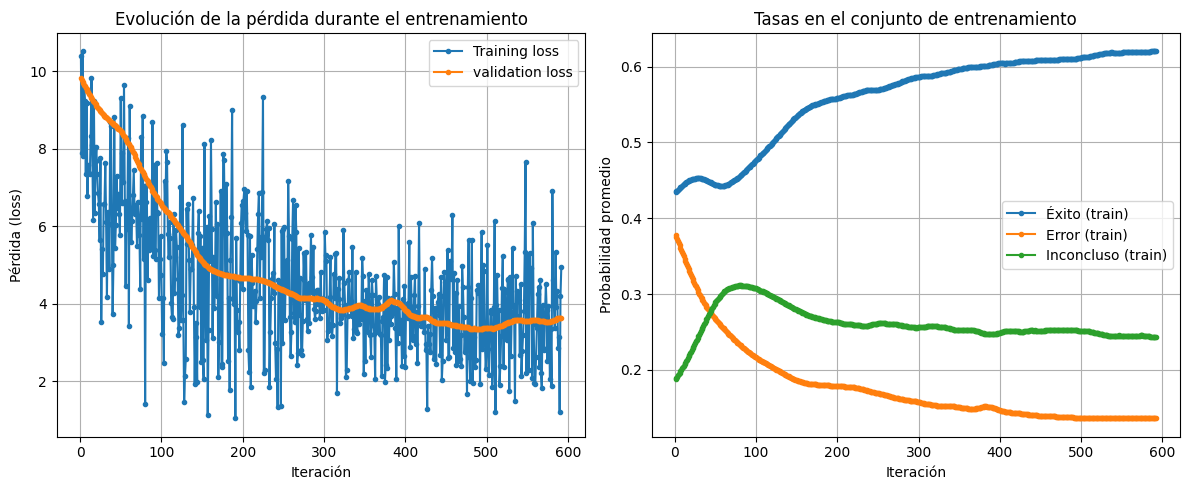

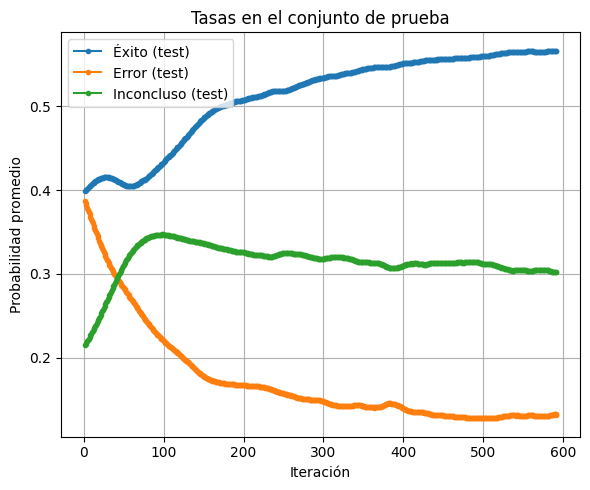

In [13]:
# Visualización de los resultados
plt.figure(figsize=(12,5))

# Evolución de la pérdida
plt.subplot(1,2,1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss")
plt.plot(range(1, it+1), val_loss_history, '.-', label="validation loss")
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la pérdida durante el entrenamiento")
plt.grid()
plt.legend()

# Éxito, Error e Inconcluso en train
plt.subplot(1,2,2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito (train)")
plt.plot(range(1, it+1), train_err_history, '.-', label="Error (train)")
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso (train)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de entrenamiento")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Figura para test
plt.figure(figsize=(6,5))

# Éxito, Error e Inconcluso en test
plt.plot(range(1, it+1), test_suc_history, '.-', label="Éxito (test)")
plt.plot(range(1, it+1), test_err_history, '.-', label="Error (test)")
plt.plot(range(1, it+1), test_inc_history, '.-', label="Inconcluso (test)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de prueba")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

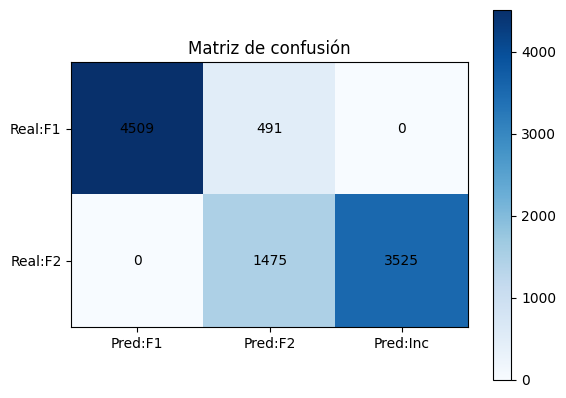

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
